In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow import keras
from keras import initializers
from keras.layers import ReLU, Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from keras.layers import Input, concatenate, Conv2D, Flatten, Dropout
from keras import Model
from keras.models import save_model, load_model
# from google.colab import files

### Loading dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

### Model 1

In [5]:
def build_generator(latent_dim, n_classes):
    input_latent = Input((latent_dim,))
    input_labels = Input((n_classes,))
    generator_input = concatenate([input_latent, input_labels])

    gen_model = Dense(4 * 4 * 256, use_bias=False)(generator_input)
    gen_model = ReLU()(gen_model)
    gen_model = Reshape((4, 4, 256))(gen_model)
    gen_model = Conv2DTranspose(192, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)(gen_model)
    gen_model = BatchNormalization()(gen_model)
    gen_model = ReLU()(gen_model)
    gen_model = Conv2DTranspose(96, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)(gen_model)
    gen_model = BatchNormalization()(gen_model)
    gen_model = ReLU()(gen_model)
    gen_model = Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(gen_model)
    # gen_model = BatchNormalization()(gen_model)
    # gen_model = ReLU()(gen_model)
    # gen_model = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')(gen_model)

    generator = Model(inputs=[input_latent, input_labels], outputs=gen_model)
    return generator

def build_discriminator(n_classes):
    discriminator_input = Input((32, 32, 3))
    disc_model = Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same')(discriminator_input)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)
    
    disc_model = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)
    
    disc_model = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Flatten()(disc_model)
    disc_output_d = Dense(1, activation='sigmoid')(disc_model)
    disc_output_c = Dense(n_classes, activation='softmax')(disc_model)

    discriminator = Model(inputs=discriminator_input, outputs=[disc_output_d, disc_output_c])
    return discriminator

def generator_loss(generated_output, labels):
    out_d, out_c = generated_output
    loss_d = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(out_d), out_d)
    loss_c = tf.losses.CategoricalCrossentropy(from_logits=True)(labels, out_c)
    return loss_d + loss_c

def discriminator_loss(real_output, generated_output, labels):
    real_out_d, real_out_c = real_output
    real_loss_d = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_out_d), real_out_d)
    real_loss_c = tf.losses.CategoricalCrossentropy(from_logits=True)(labels, real_out_c)
    real_loss = real_loss_d + real_loss_c

    generated_out_d, generated_out_c = generated_output
    generated_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_out_d), generated_out_d)
    total_loss = real_loss + generated_loss

    return total_loss

### Model 2

In [3]:
def build_generator(latent_dim, n_classes):
    init_weights = initializers.RandomNormal(mean=0.0, stddev=0.02, seed=0)
    init_bias = initializers.Zeros()

    input_latent = Input((latent_dim,))
    input_labels = Input((n_classes,))
    generator_input = concatenate([input_latent, input_labels])

    gen_model = Dense(4 * 4 * 384, kernel_initializer=init_weights, bias_initializer=init_bias)(generator_input)
    gen_model = ReLU()(gen_model)
    gen_model = Reshape((4, 4, 384))(gen_model)
    gen_model = Conv2DTranspose(192, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(gen_model)
    gen_model = BatchNormalization()(gen_model)
    gen_model = ReLU()(gen_model)
    gen_model = Conv2DTranspose(96, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(gen_model)
    gen_model = BatchNormalization()(gen_model)
    gen_model = ReLU()(gen_model)
    gen_model = Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias, activation='tanh')(gen_model)
    # gen_model = BatchNormalization()(gen_model)
    # gen_model = ReLU()(gen_model)
    # gen_model = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')(gen_model)

    generator = Model(inputs=[input_latent, input_labels], outputs=gen_model)
    return generator

def build_discriminator(n_classes):
    init_weights = initializers.RandomNormal(mean=0.0, stddev=0.02, seed=0)
    init_bias = initializers.Zeros()

    discriminator_input = Input((32, 32, 3))
    disc_model = Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(discriminator_input)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)
    
    disc_model = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)
    
    disc_model = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=init_weights, bias_initializer=init_bias)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Flatten()(disc_model)
    disc_output_d = Dense(1, activation='sigmoid')(disc_model)
    disc_output_c = Dense(n_classes, activation='softmax')(disc_model)

    discriminator = Model(inputs=discriminator_input, outputs=[disc_output_d, disc_output_c])
    return discriminator

def generator_loss(generated_output, labels):
    out_d, out_c = generated_output
    loss_d = tf.losses.BinaryCrossentropy()(tf.ones_like(out_d), out_d)
    loss_c = tf.losses.CategoricalCrossentropy()(labels, out_c)
    return loss_d + loss_c

def discriminator_loss(real_output, generated_output, labels):
    real_out_d, real_out_c = real_output
    real_loss_d = tf.losses.BinaryCrossentropy()(tf.ones_like(real_out_d), real_out_d)
    real_loss_c = tf.losses.CategoricalCrossentropy()(labels, real_out_c)
    real_loss = real_loss_d + real_loss_c

    generated_out_d, generated_out_c = generated_output
    generated_loss = tf.losses.BinaryCrossentropy()(tf.zeros_like(generated_out_d), generated_out_d)
    total_loss = real_loss + generated_loss

    return total_loss


### Pre-preccessing & Parameter Initialization

In [4]:
def normalize_image(img, method="centered"):
    img = np.array(img).astype(np.float32)
    if(method == "centered"):
        return (img - 127.5) / 127.5
    elif(method == "simple"):
        return (img / 255)
    else:
        return (img / 255)

def img_to_uint8(img):
    return np.uint8(img * 127.5 + 128).clip(0, 255)

def one_hot_encode_label(label):
    return tf.one_hot(label, 10)

In [5]:
train_img_normalzied = normalize_image(train_images)
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels[:, 0]).map(one_hot_encode_label)
train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_normalzied)

buffer_size = train_img_normalzied.shape[0]
batch_size = 100
train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(buffer_size).batch(batch_size)

latent_dim = 100
n_classes = 10
generator = build_generator(latent_dim, n_classes)
discriminator = build_discriminator(n_classes)

generator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

### Training

In [ ]:
tf.autograph.set_verbosity(0, True)
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_output, labels)
        disc_loss = discriminator_loss(real_output, generated_output, labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
EPOCHS = 450
num_examples_to_generate = 20

random_vector_for_generation = tf.random.normal([num_examples_to_generate, latent_dim])
condition_vector_generation = tf.one_hot(list(range(10)) + list(range(10)), 10)

fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
fake_concat = np.transpose(img_to_uint8(fake), [1, 0, 2, 3]).reshape((32, -1, 3))
plt.imshow(fake_concat)
plt.title(f'Fake images generated before training', fontsize=9, fontweight='bold'), plt.axis('off')
plt.show()

for epoch in range(EPOCHS):
    start_time = time.time()
    for images, labels in train_dataset:
        train_step(images, labels)
    print(f"End of training for epoch {epoch + 1}. ", f"took {np.round(time.time() - start_time, 2)}sec to train.")
    fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
    fake_concat = np.transpose(img_to_uint8(fake), [1, 0, 2, 3]).reshape((32, -1, 3))
    plt.imshow(fake_concat)
    plt.title(f'Fake images, Epoch: {epoch}', fontsize=9, fontweight='bold'), plt.axis('off')
    plt.show()

save_model(generator, "trained-models/generator.h5")
save_model(discriminator, "trained-models/discriminator.h5")

# files.download("generator-2.h5")
# files.download("discriminator-2.h5")

### Testing

In [9]:
generator = load_model("trained-models/generator-2.h5", compile=False)
discriminator = load_model("trained-models/discriminator-2.h5", compile=False)

e:\Users\AbbasMn\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [136]:
# num_examples_to_generate = 20

# random_vector_for_generation = tf.random.normal([num_examples_to_generate, latent_dim])
# condition_vector_generation = tf.one_hot(np.full(20, 8), 10)

# fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
# fake_concat = np.transpose(img_to_uint8(fake), [1, 0, 2, 3]).reshape((32, -1, 3))
# plt.imshow(fake_concat)
# plt.title(f'Fake images generated before training', fontsize=9, fontweight='bold'), plt.axis('off')
# plt.show()

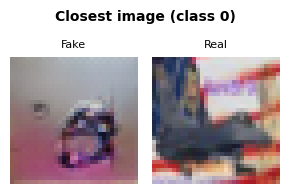

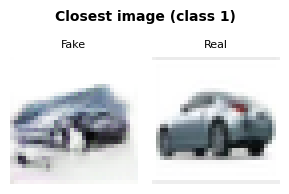

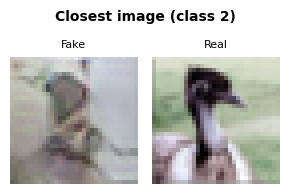

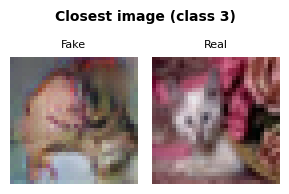

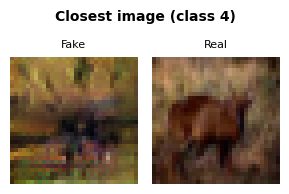

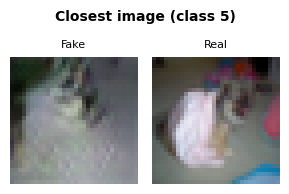

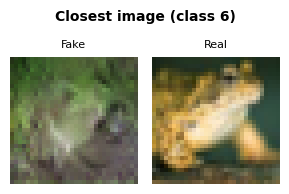

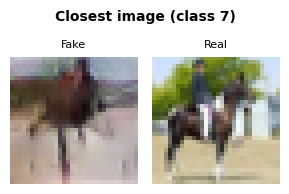

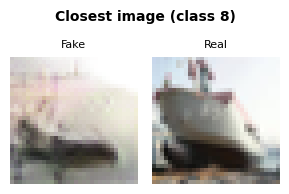

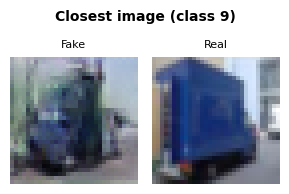

In [10]:
test_ims = normalize_image(test_images, 'simple')

for class_num in range(10):
    num_examples_to_generate = 2000
    random_vector_for_generation = tf.random.normal([num_examples_to_generate, latent_dim])
    condition_vector_generation = tf.one_hot(np.full(num_examples_to_generate, class_num), 10)
    fake_images = generator([random_vector_for_generation, condition_vector_generation], training=False)
    fake_images = img_to_uint8(fake_images)
    fake_images = normalize_image(fake_images, 'simple')
    min_dist = np.inf
    class_ims = test_ims[test_labels.flatten() == class_num]

    # real_im_closest = None
    # chosen_fake_im = None
    # for fake_im in fake_images:
    #     for real_im in test_ims:
    #         dist = np.linalg.norm(fake_im-real_im)
    #         if (dist < min_dist):
    #             min_dist = dist
    #             real_im_closest = real_im
    #             chosen_fake_im = fake_im

    class_ims = test_ims[test_labels.flatten() == class_num]
    real_im = class_ims[np.random.randint(len(class_ims))]
    fake_im_closest = None
    for fake_im in fake_images:
        dist = np.linalg.norm(fake_im-real_im)
        if (dist < min_dist):
            min_dist = dist
            chosen_fake_im = fake_im

    plt.figure(figsize=(3, 2))
    plt.suptitle(f'Closest image (class {class_num})', fontsize=10, fontweight='bold')
    plt.subplot(121), plt.imshow(chosen_fake_im, cmap='gray')
    plt.title('Fake', fontsize=8), plt.axis('off')
    plt.subplot(122), plt.imshow(real_im, cmap='gray')
    plt.title('Real', fontsize=8), plt.axis('off')
    plt.tight_layout()
    plt.show()